In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block -- MOST IMPORTANT TO CHECK VLAUES

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'CAD'
share_name = 'EMA.TO'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-03-31,1050,-10,1041,213,126,664,230,1412,214,...,430,453,330,1519,3196,6204,146,-81,143,2014-05-10
1,2014-06-30,567,-37,530,35,72,439,239,1186,207,...,309,436,327,1361,2984,5824,264,-55,143,2014-08-09
2,2014-09-30,562,-32,531,49,105,418,270,1270,217,...,298,326,272,1309,3272,6153,175,-117,143,2014-11-09
3,2014-12-31,793,-23,770,155,160,486,295,1412,222,...,371,259,95,1123,3660,6455,177,-176,143,2015-02-24
4,2015-03-31,889,-3,891,174,236,603,283,1646,242,...,384,8,93,905,3800,6500,120,-83,146,2015-05-10


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
35,2022-12-31,2023-02-24,270,2358,0,2358,499,310,1503,769,...,0,39742,2025,2726,574,7287,15744,28315,-42,-892
36,2023-03-31,2023-05-10,271,2433,0,2433,576,280,1156,735,...,0,38817,1304,2833,682,5908,15807,26940,453,-637
37,2023-06-30,2023-08-09,273,1418,0,1418,44,313,1032,826,...,0,38472,1283,2852,96,5267,16441,26887,498,-714
38,2023-09-30,2023-11-09,274,1740,0,1740,118,254,1111,840,...,0,39147,1424,2666,676,5873,16243,27377,867,-712
39,2023-12-31,2024-02-24,284,1972,0,1972,240,567,1817,790,...,0,39480,1454,1433,676,4544,17689,27392,423,-874


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-24,270,2358,0,2358,499,310,1503,769,...,39742,2025,2726,574,7287,15744,28315,-42,-892,1.357405
36,2023-03-31,2023-05-10,271,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
37,2023-06-30,2023-08-09,273,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
38,2023-09-30,2023-11-09,274,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
39,2023-12-31,2024-02-24,284,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
35,2022-12-31,2023-02-24,270,2358,0,2358,499,310,1503,769,...,39742,2025,2726,574,7287,15744,28315,-42,-892,1.357405
36,2023-03-31,2023-05-10,271,2433,0,2433,576,280,1156,735,...,38817,1304,2833,682,5908,15807,26940,453,-637,1.352063
37,2023-06-30,2023-08-09,273,1418,0,1418,44,313,1032,826,...,38472,1283,2852,96,5267,16441,26887,498,-714,1.343352
38,2023-09-30,2023-11-09,274,1740,0,1740,118,254,1111,840,...,39147,1424,2666,676,5873,16243,27377,867,-712,1.341033
39,2023-12-31,2024-02-24,284,1972,0,1972,240,567,1817,790,...,39480,1454,1433,676,4544,17689,27392,423,-874,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-05-12,21.540464,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.332185,0.667815,0.0,0.0,0.0,0.0,0.991429,0.202857,0.0,0.0
1,2014-05-19,21.661409,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.332185,0.667815,0.0,0.0,0.0,0.0,0.991429,0.202857,0.0,0.0
2,2014-05-26,21.661409,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.332185,0.667815,0.0,0.0,0.0,0.0,0.991429,0.202857,0.0,0.0
3,2014-06-02,21.413158,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.332185,0.667815,0.0,0.0,0.0,0.0,0.991429,0.202857,0.0,0.0
4,2014-06-09,21.489542,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.332185,0.667815,0.0,0.0,0.0,0.0,0.991429,0.202857,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-05-12,21.540464,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.0,0.991429,0.202857,0.0,0.0,inf,0.998149,0.733402,2.180544,inf
1,2014-05-19,21.661409,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.0,0.991429,0.202857,0.0,0.0,inf,1.003753,0.737519,2.184662,inf
2,2014-05-26,21.661409,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.0,0.991429,0.202857,0.0,0.0,inf,1.003753,0.737519,2.184662,inf
3,2014-06-02,21.413158,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.0,0.991429,0.202857,0.0,0.0,inf,0.992249,0.729067,2.176210,inf
4,2014-06-09,21.489542,2014-03-31,1050.0,0.0,21.58042,143.0,0.0,0.0,126.0,...,0.0,0.991429,0.202857,0.0,0.0,inf,0.995789,0.731668,2.178811,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

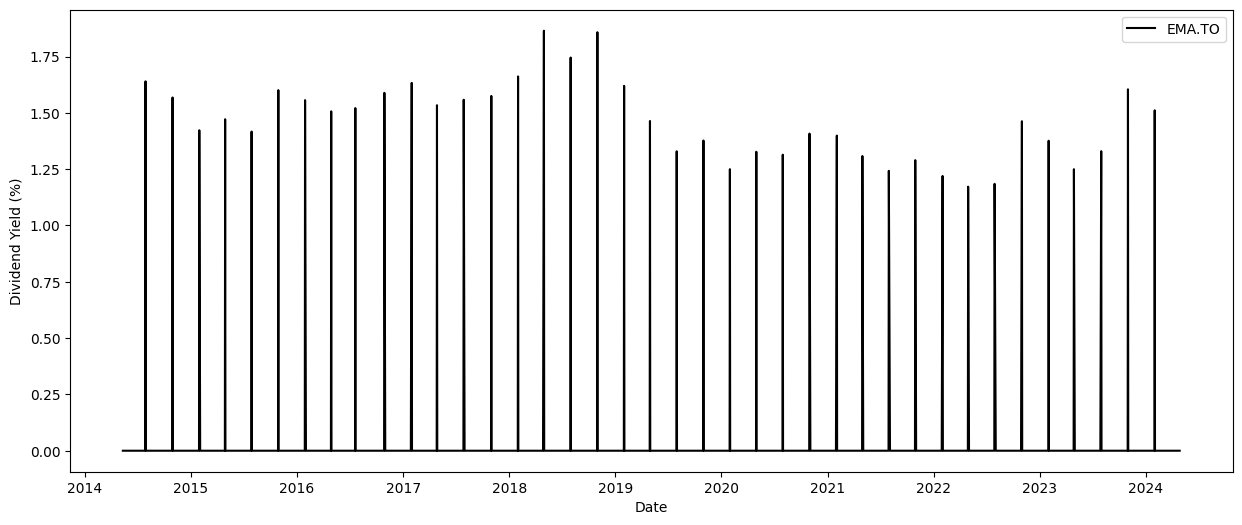

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.391006
share_price      1.000000
Name: share_price, dtype: float64


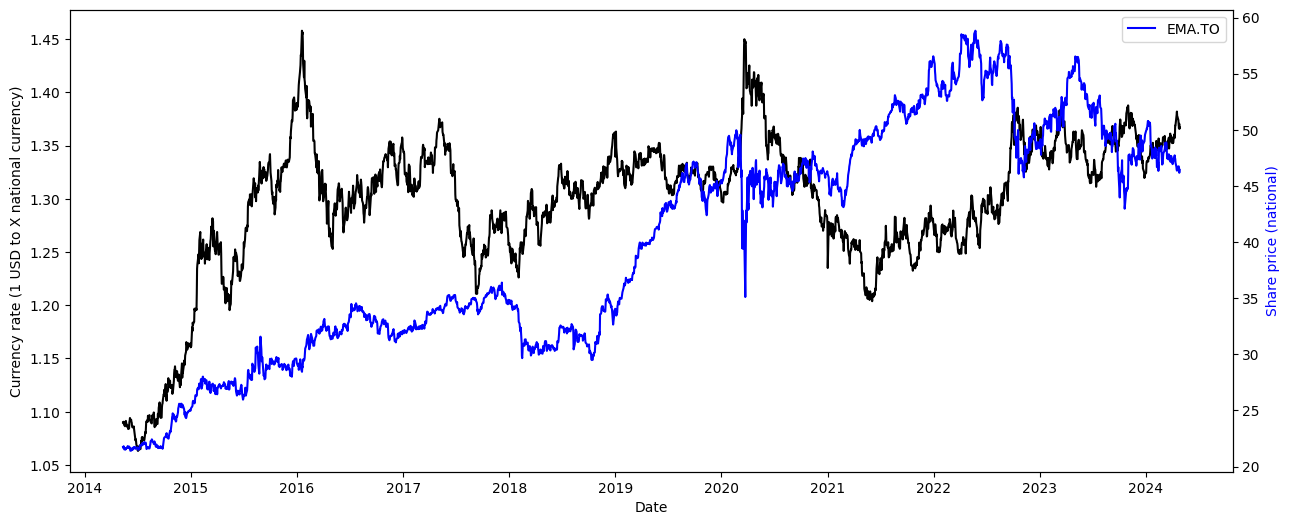

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

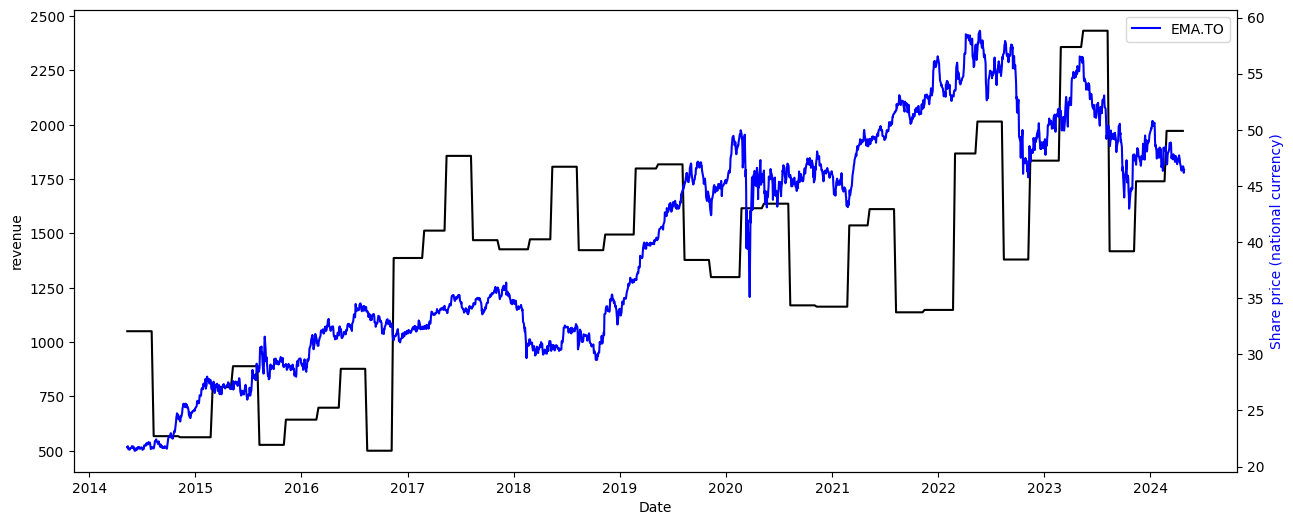

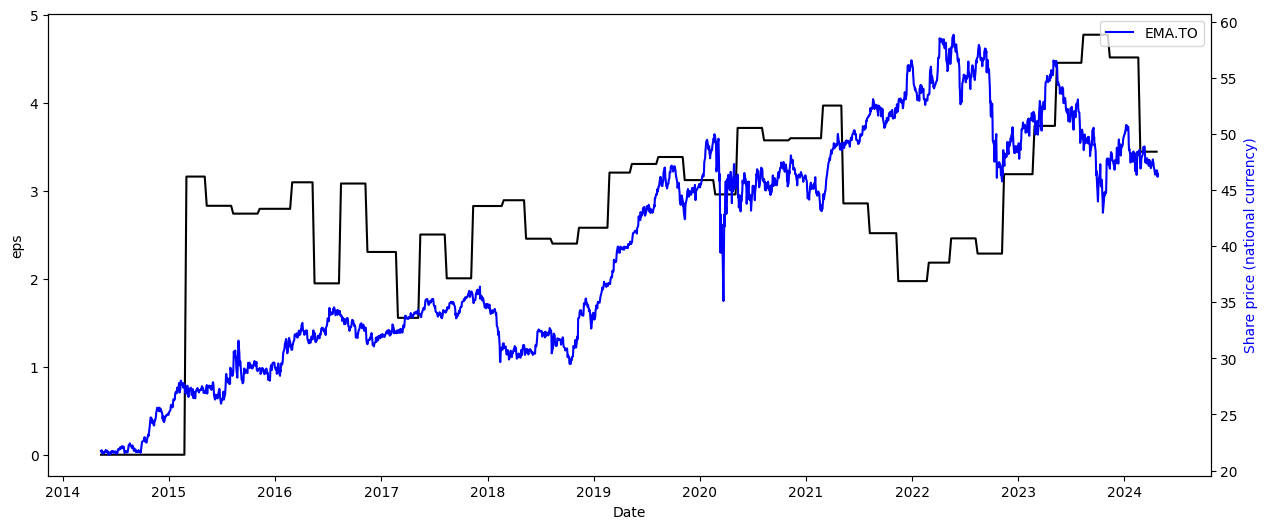

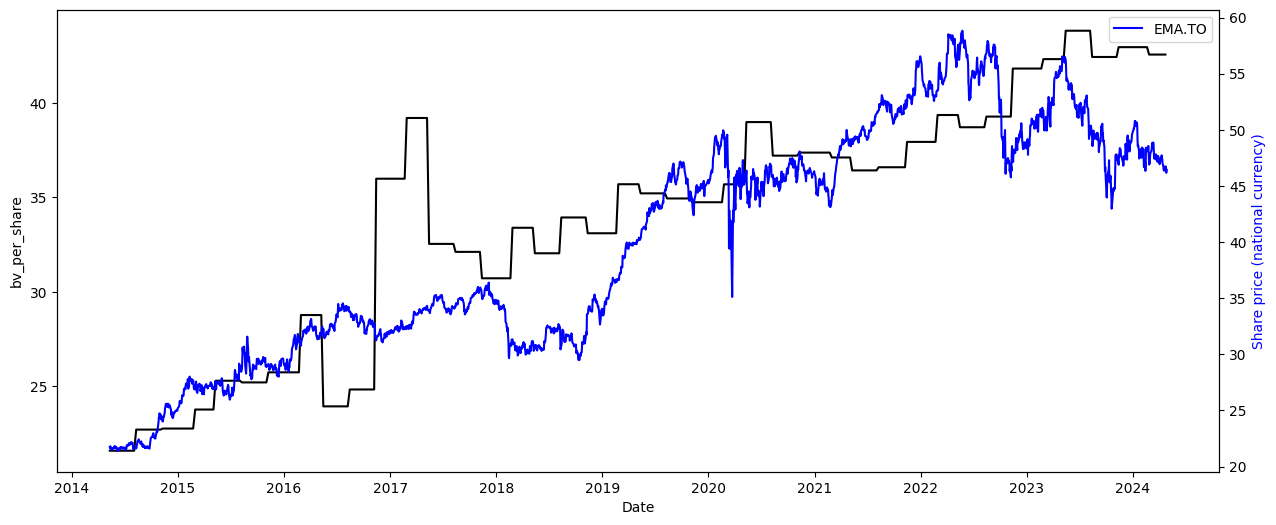

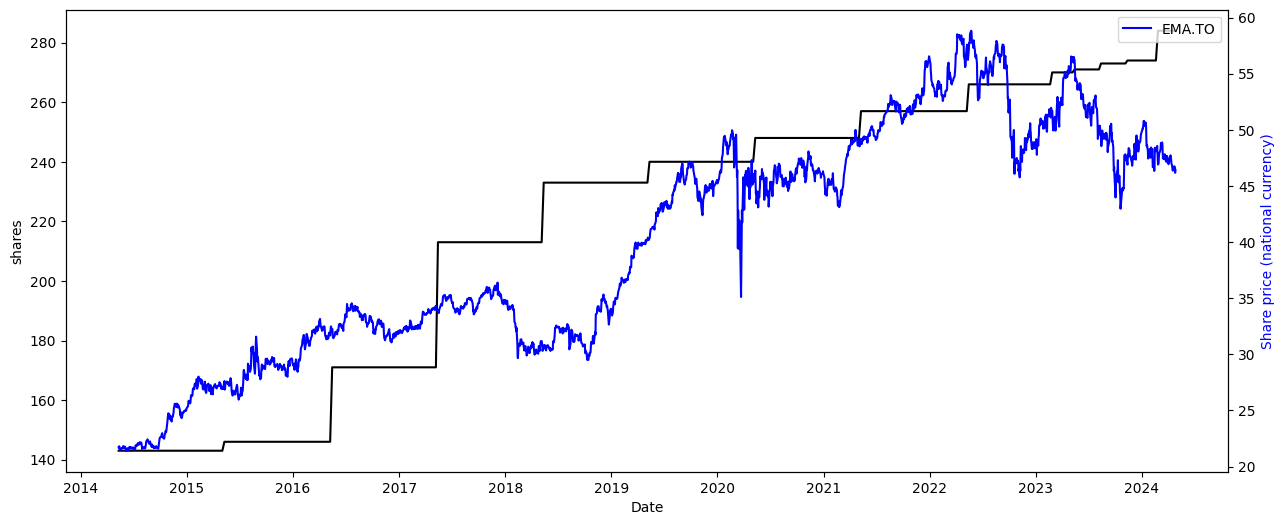

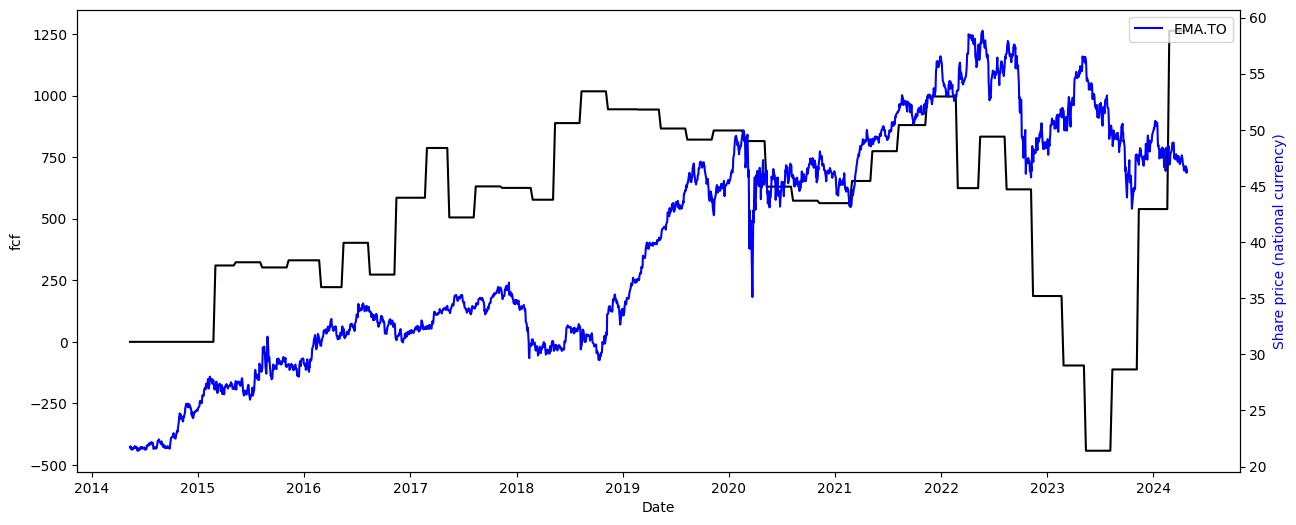

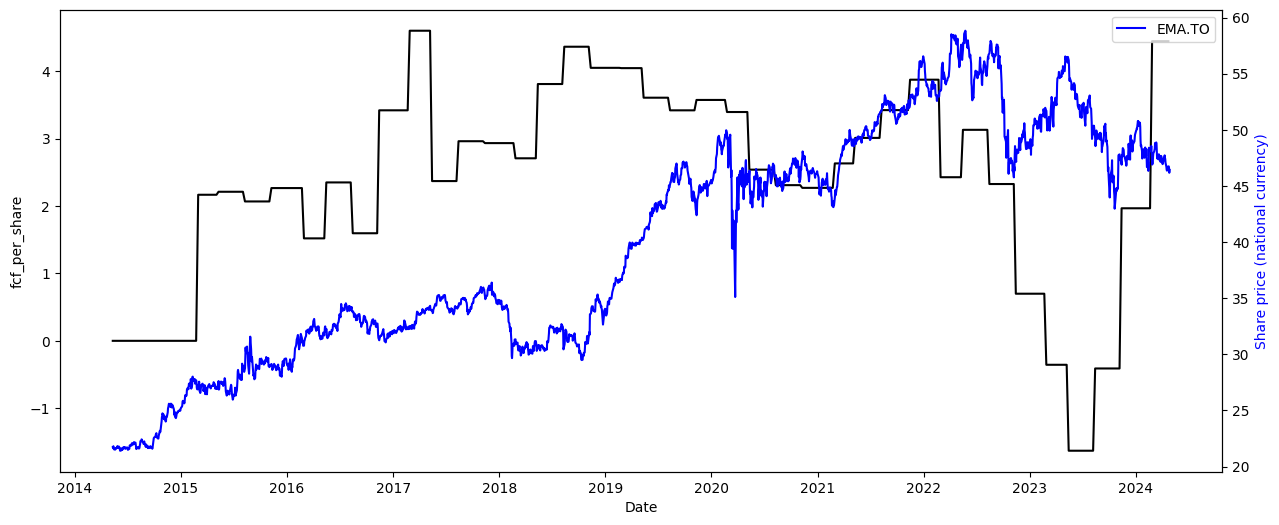

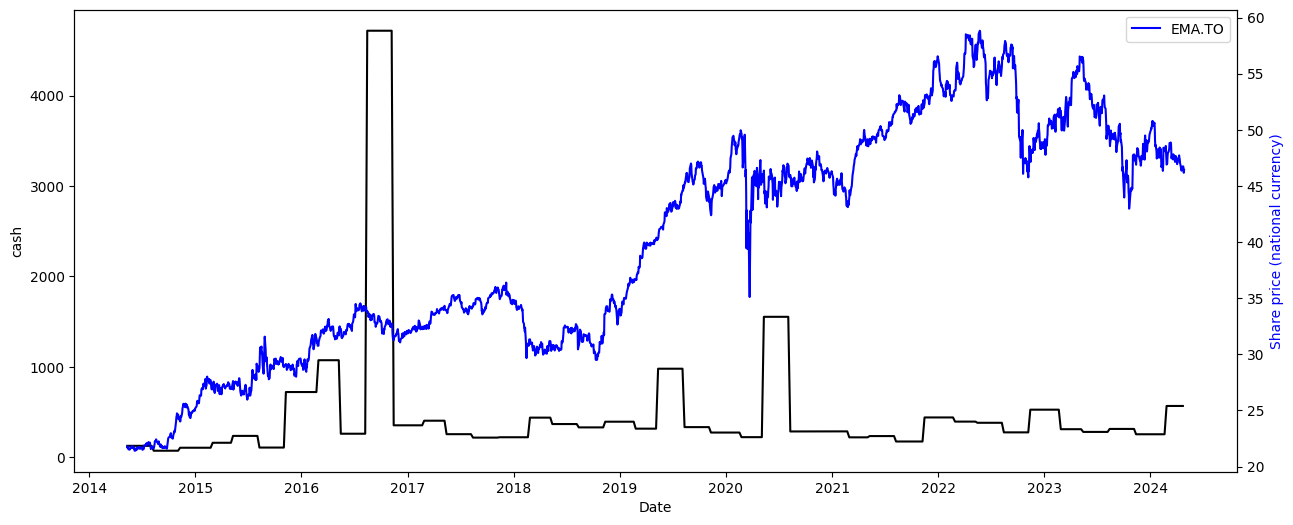

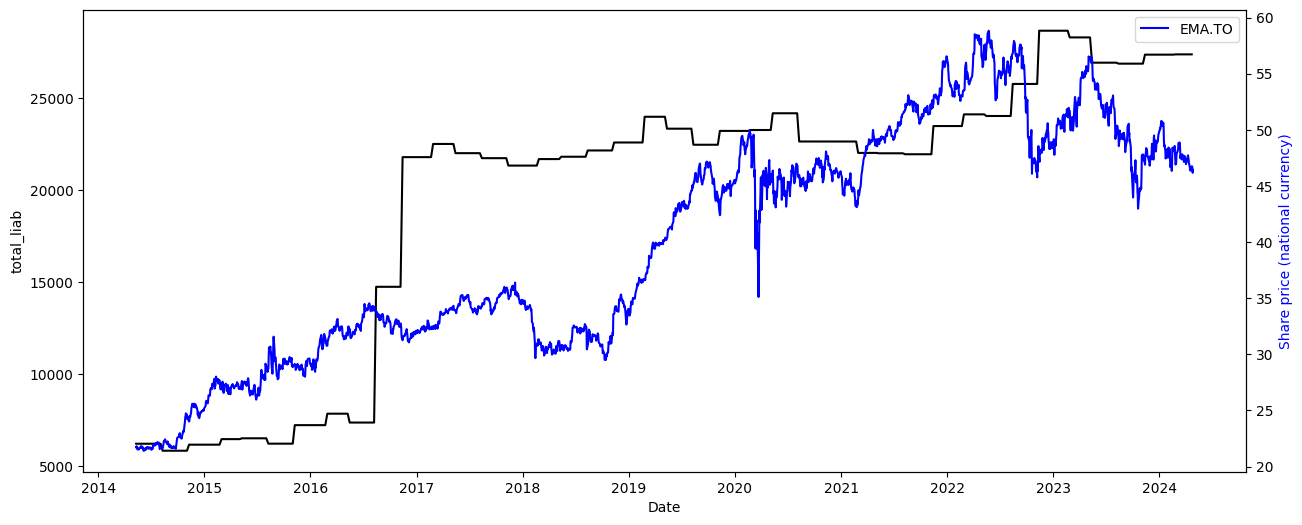

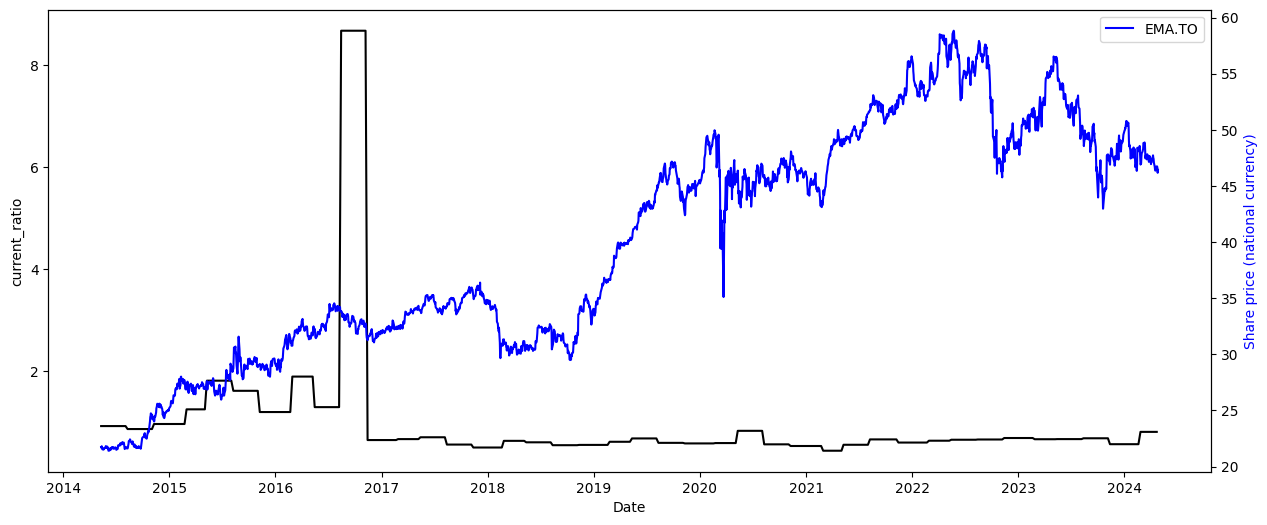

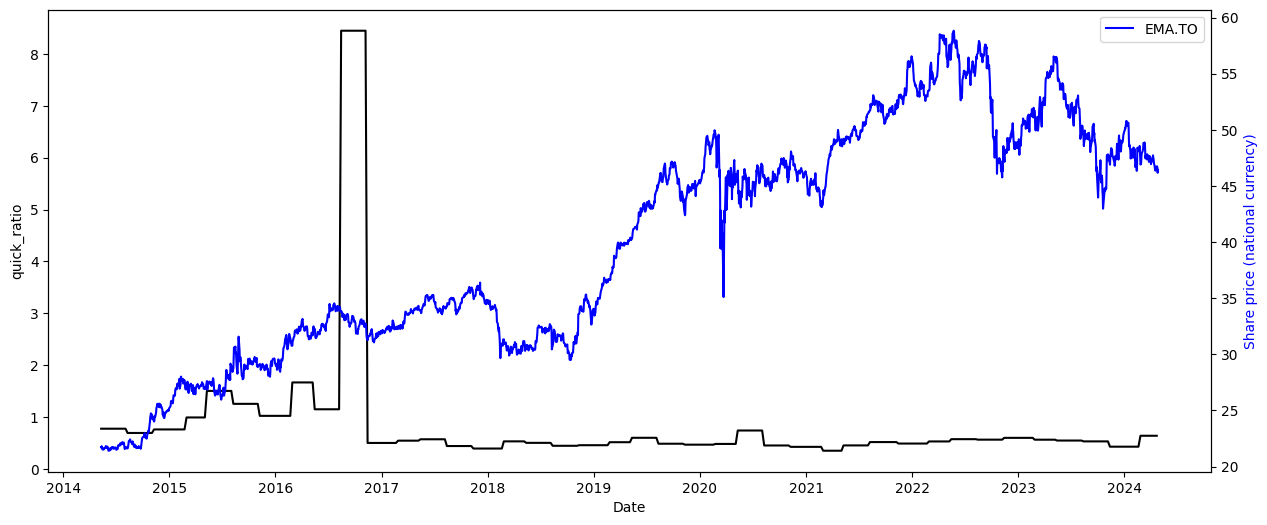

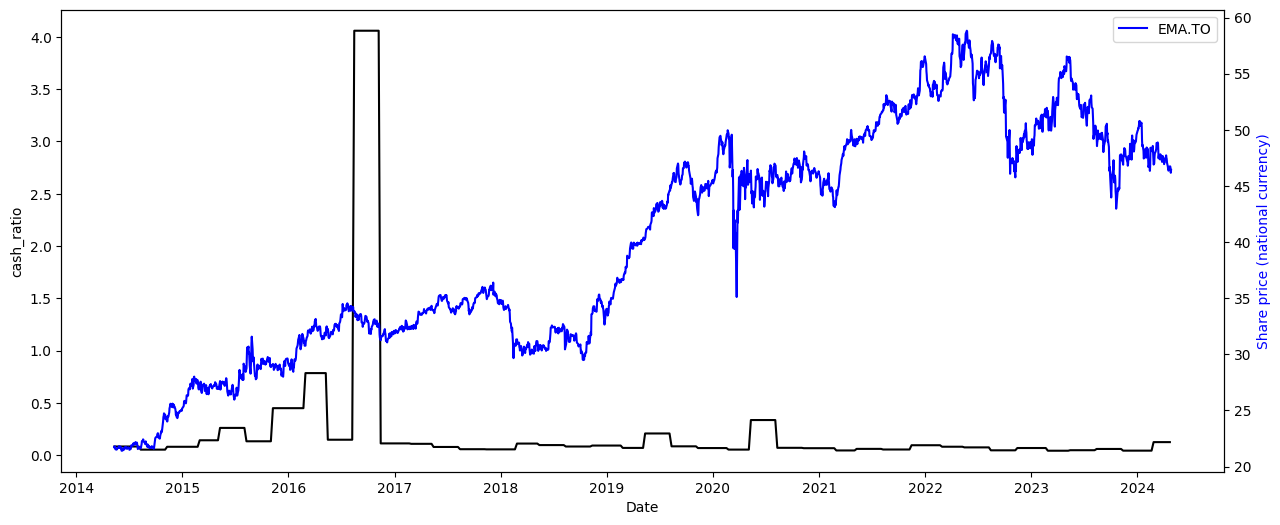

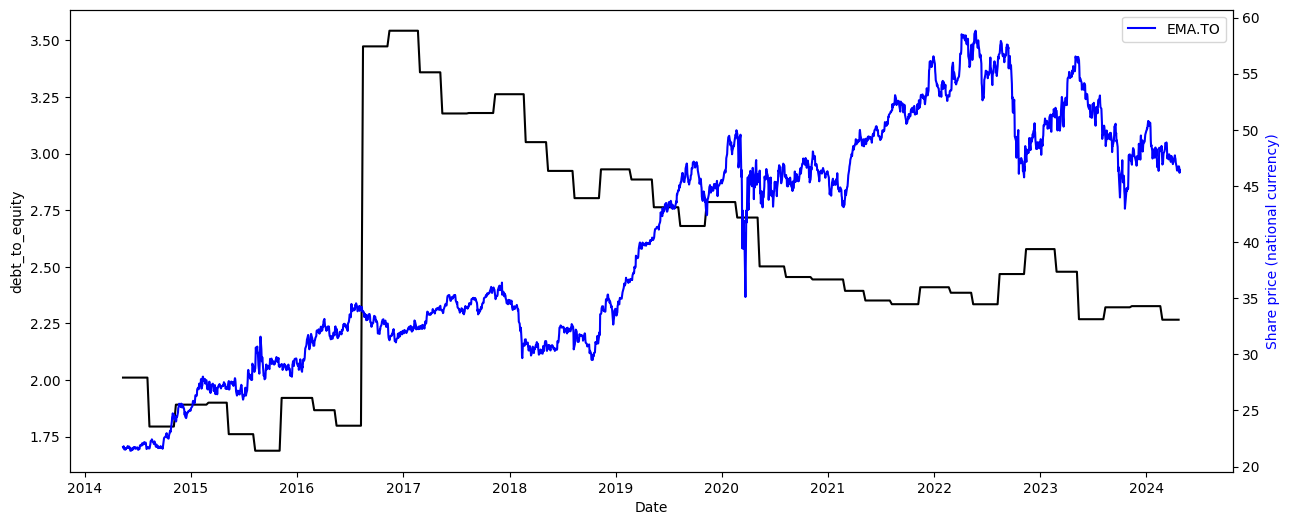

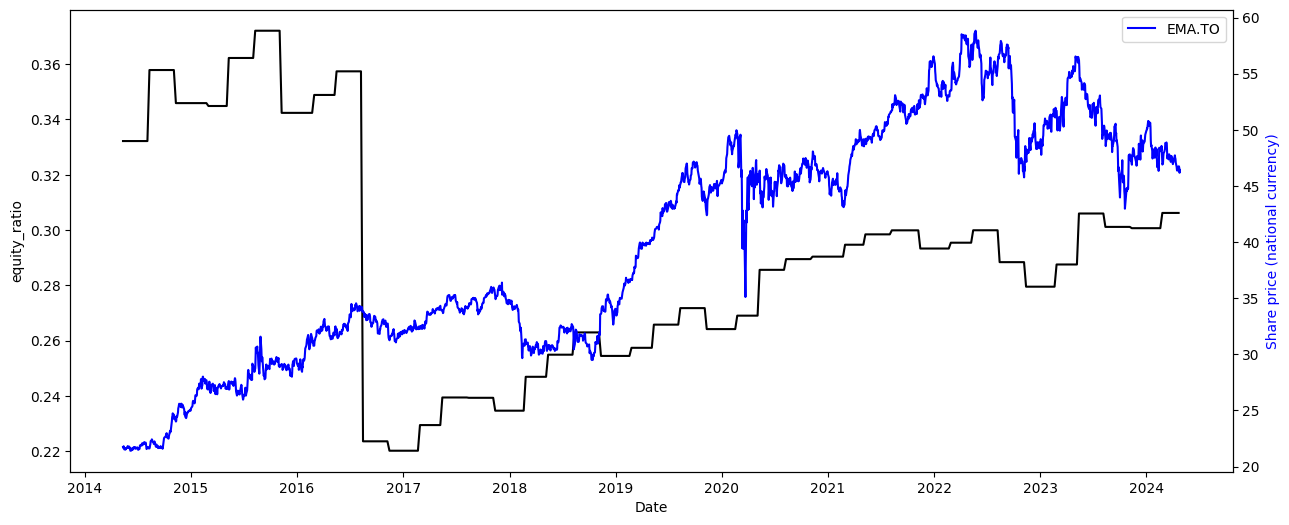

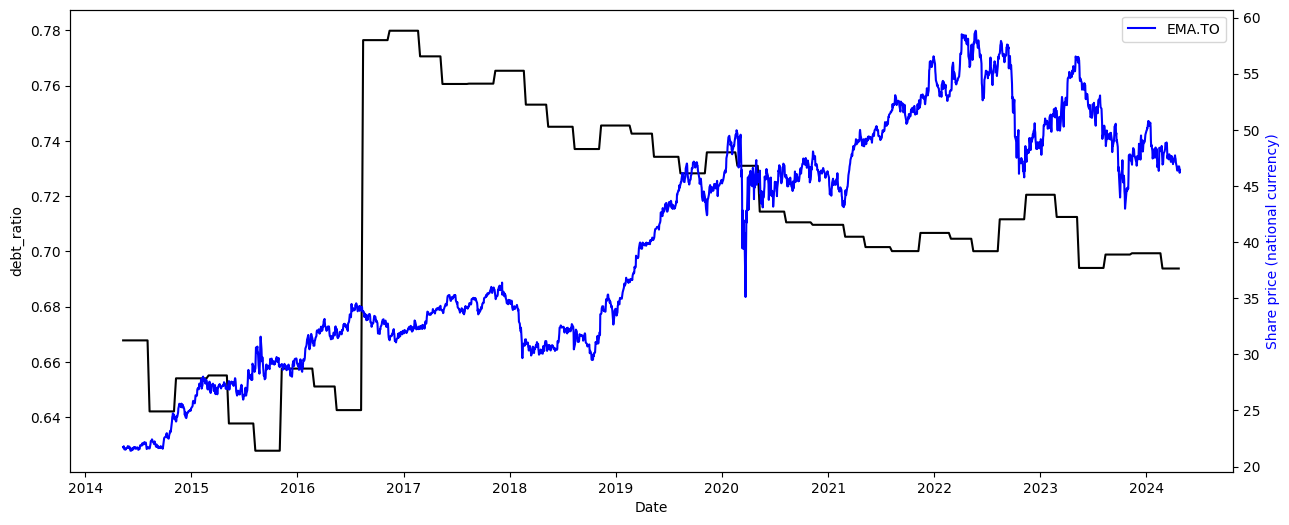

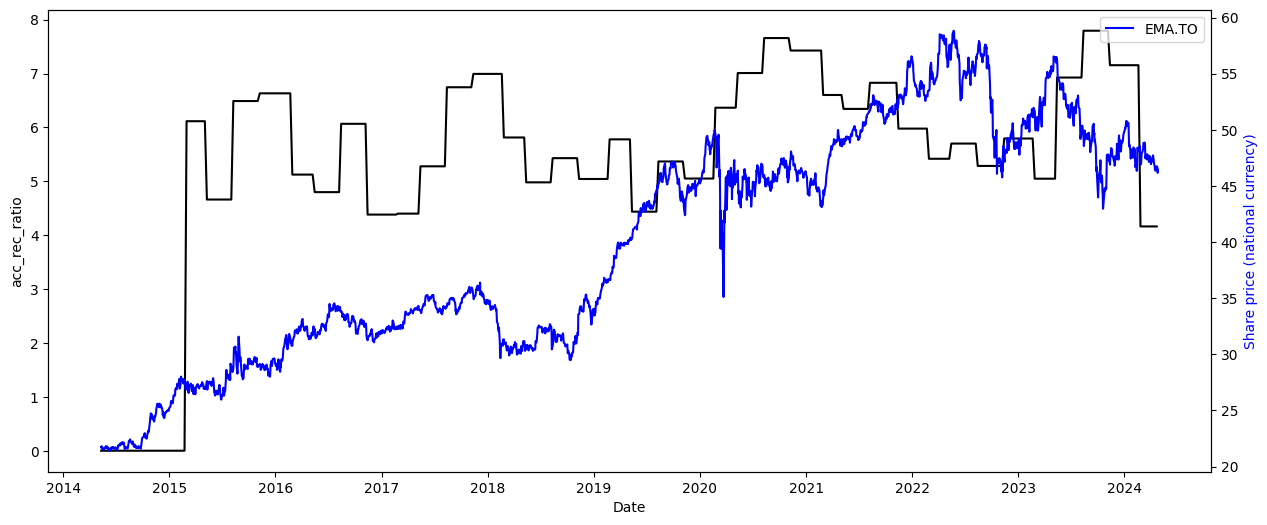

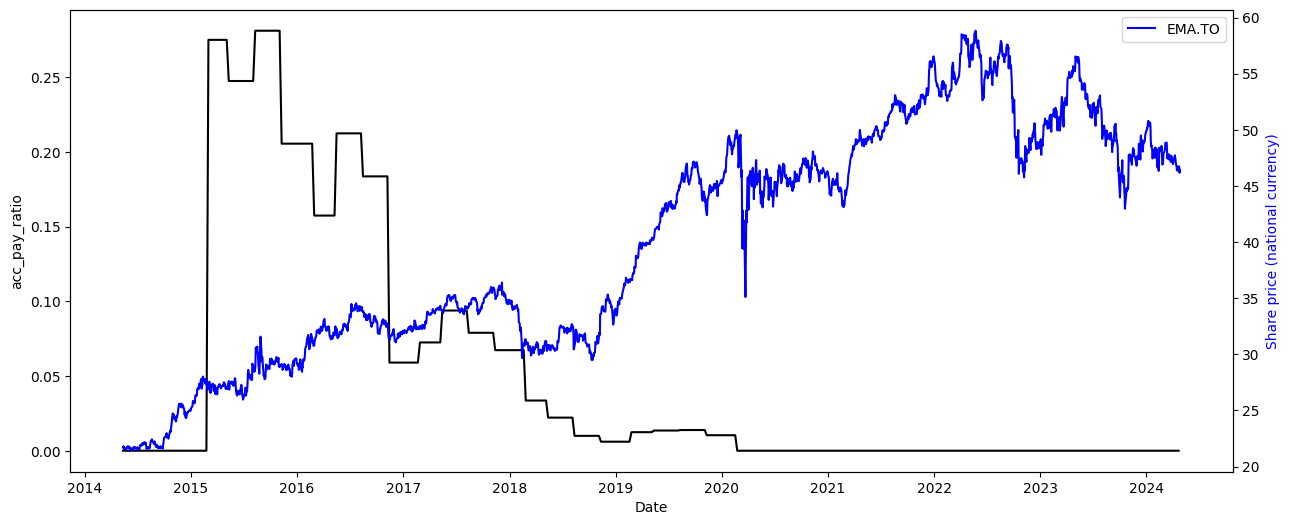

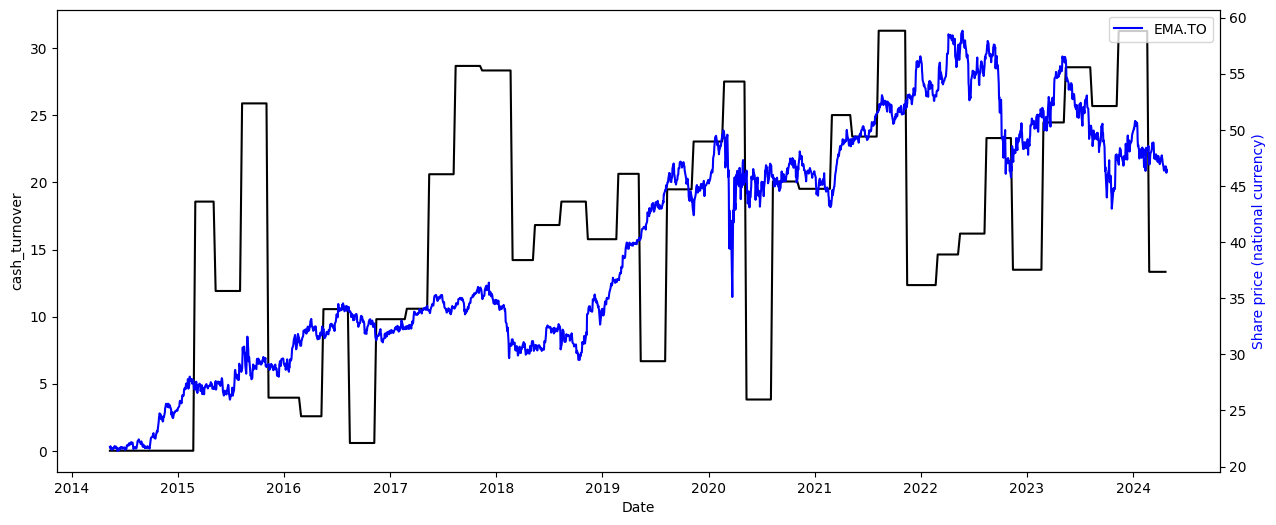

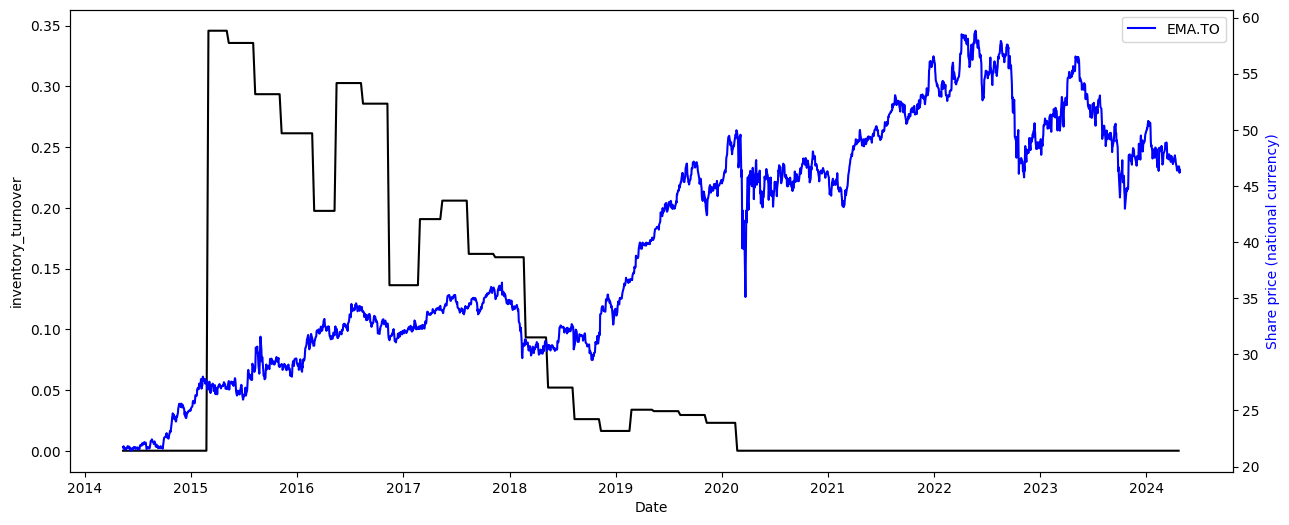

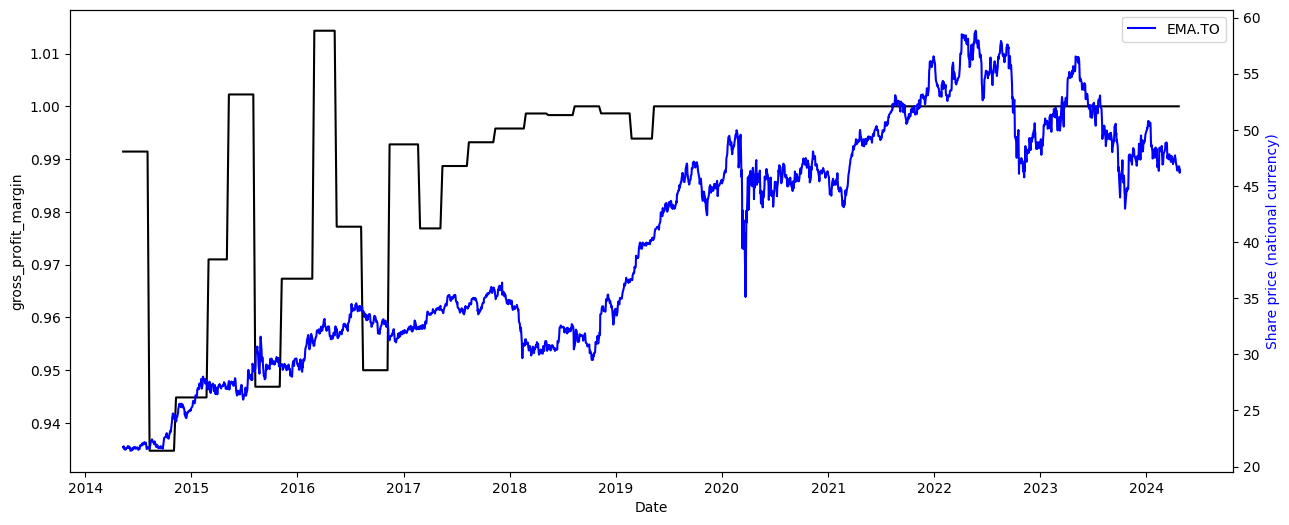

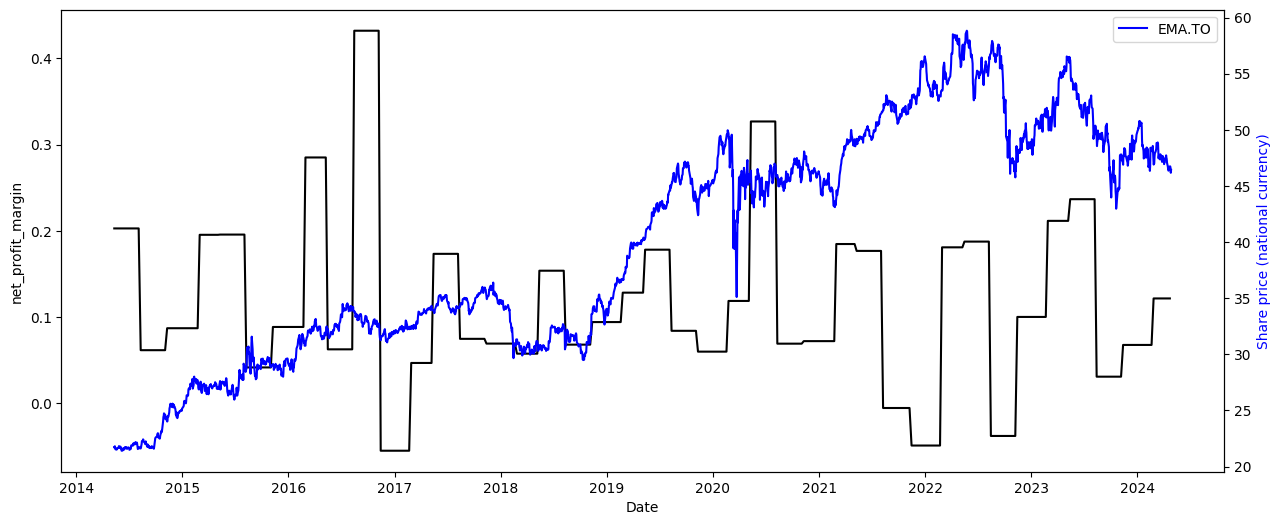

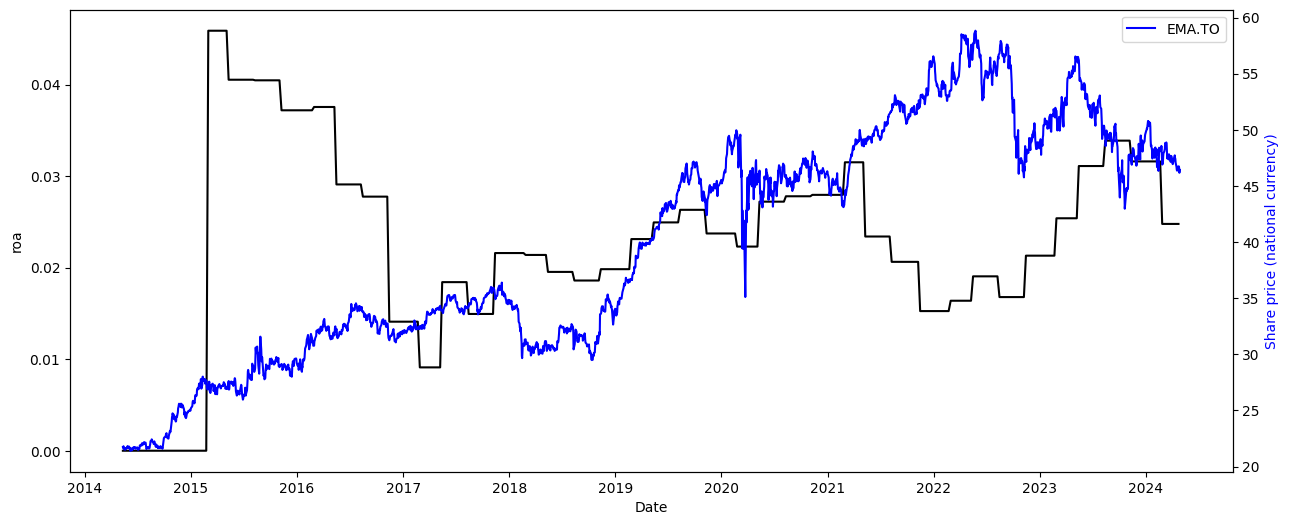

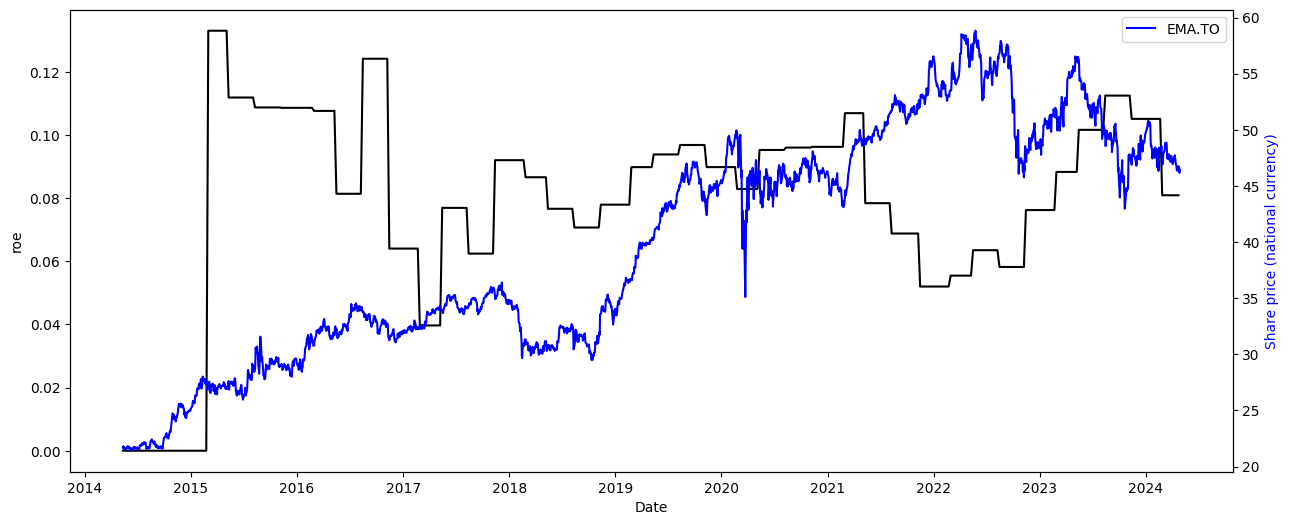

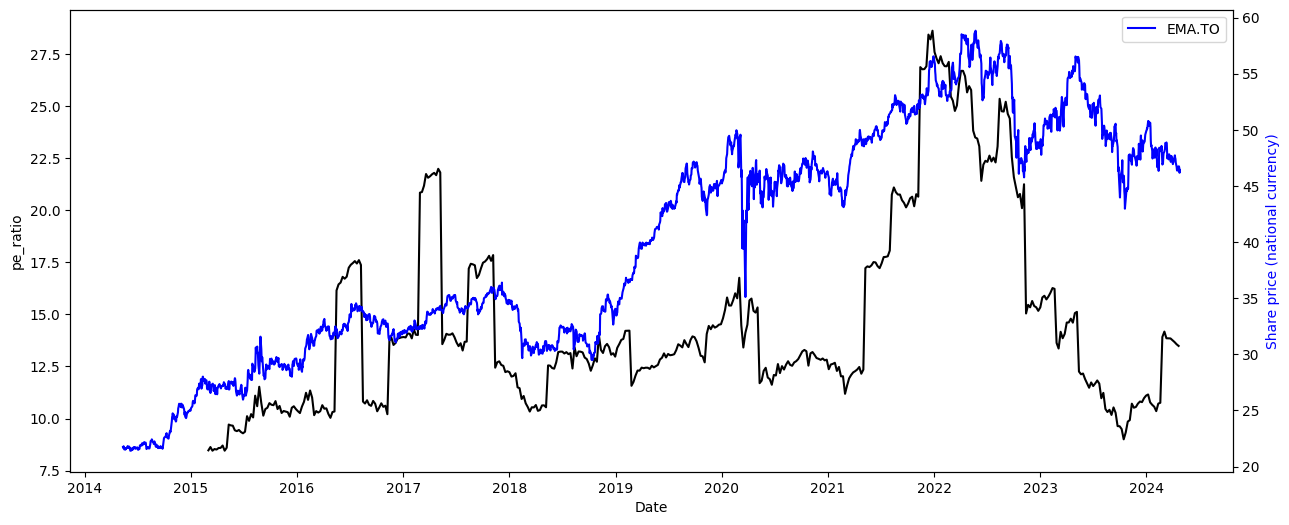

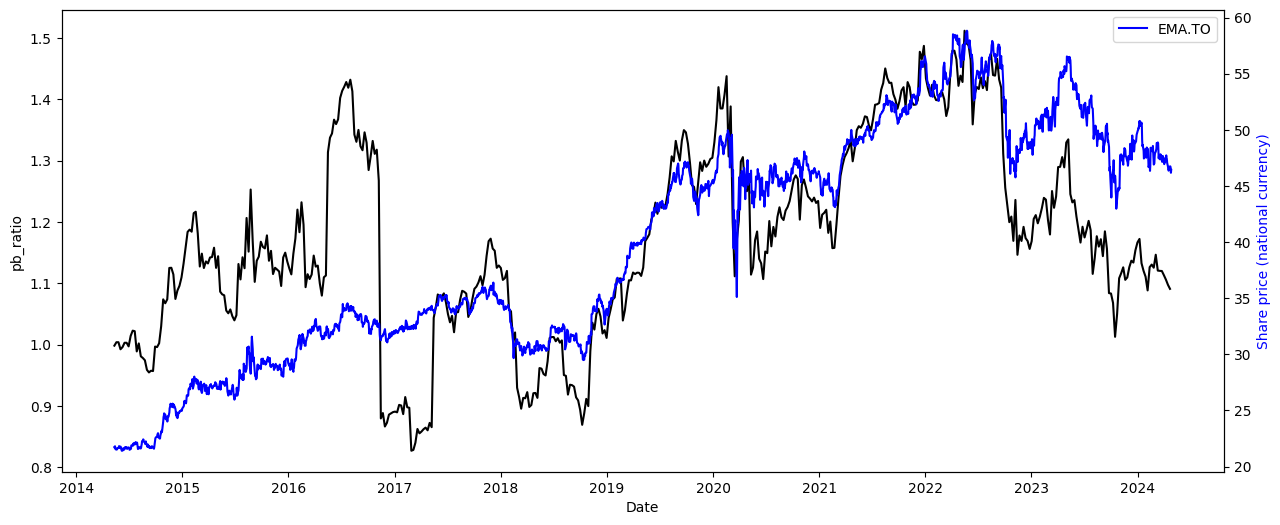

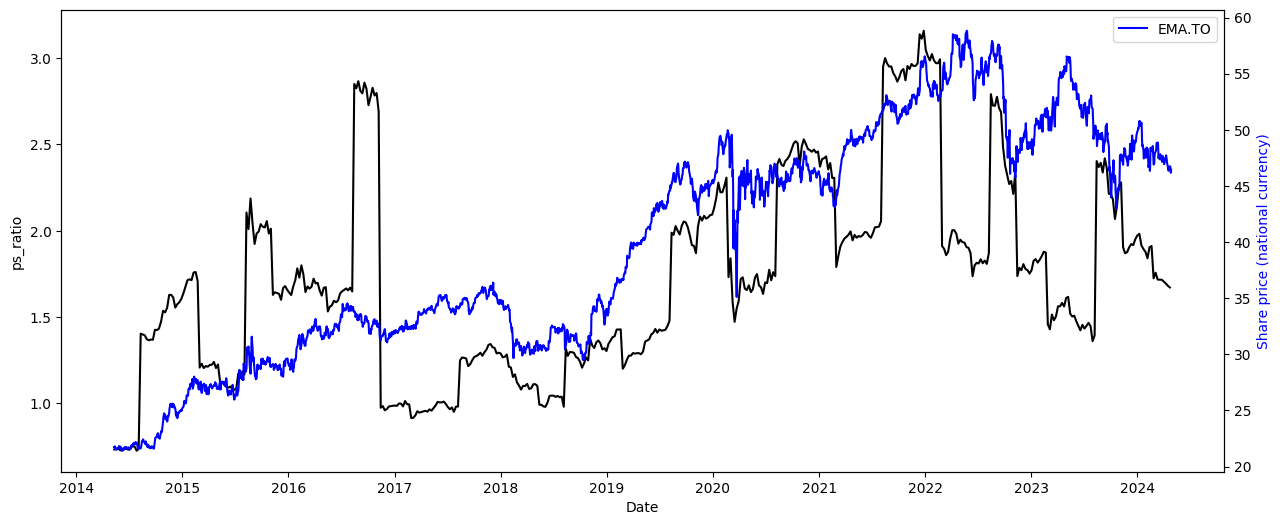

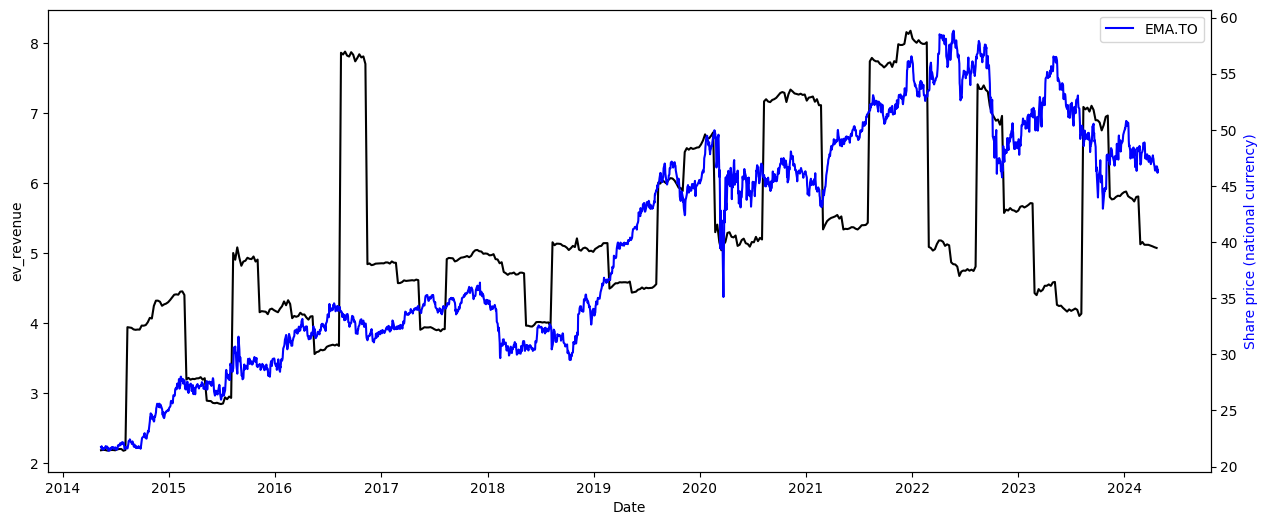

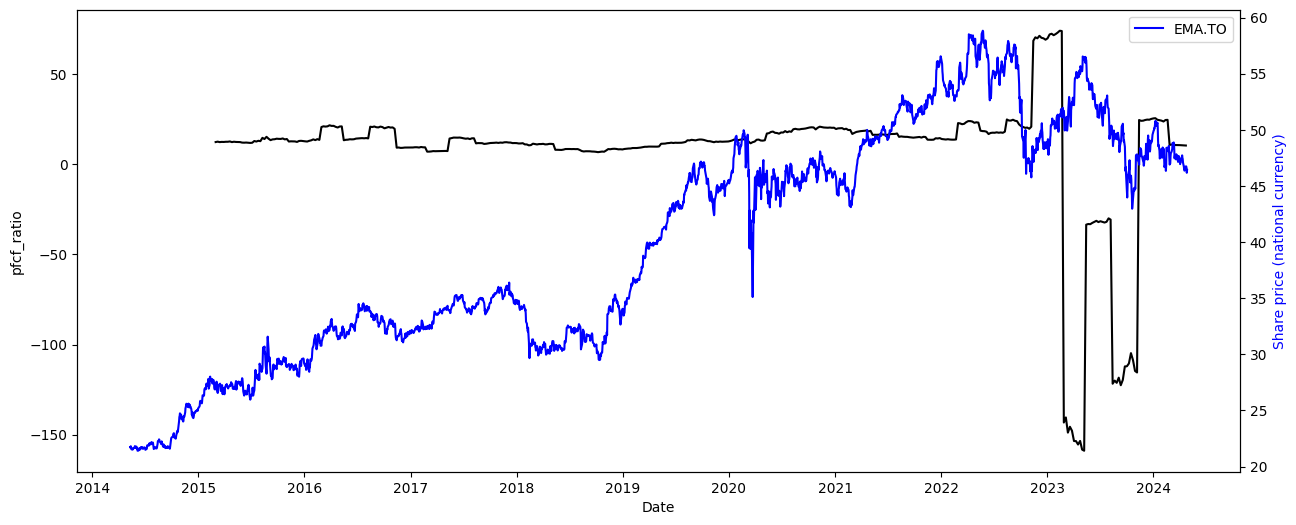

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

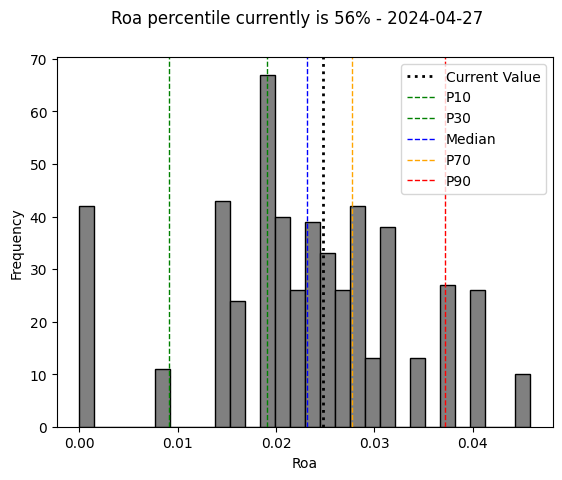

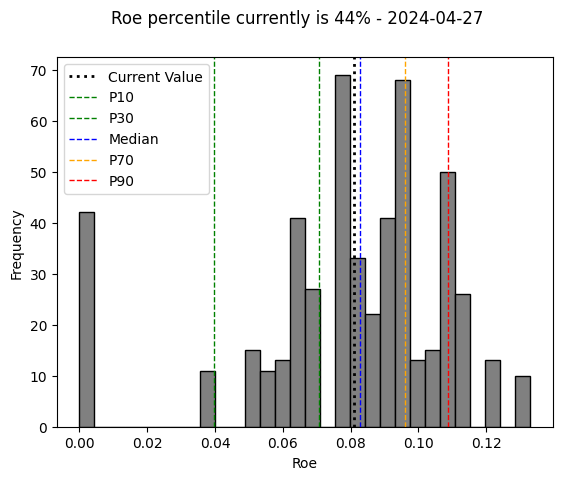

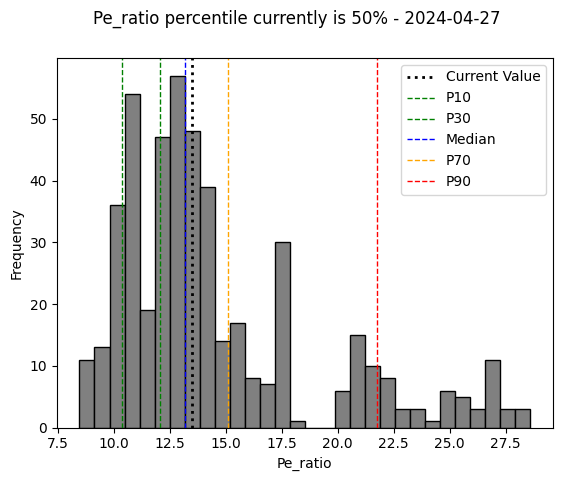

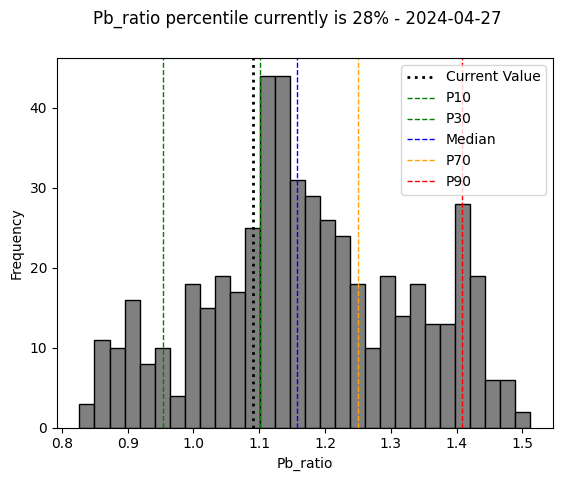

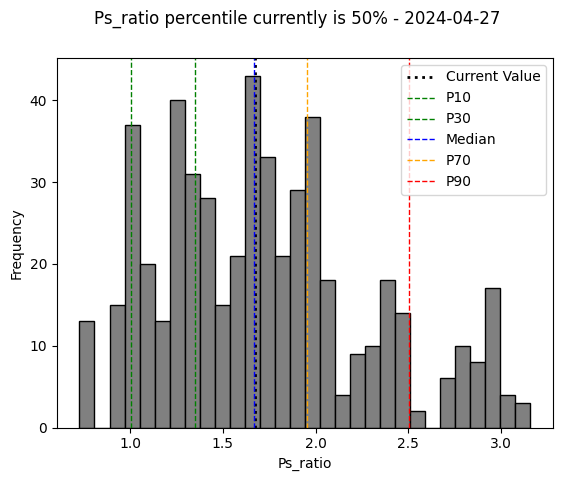

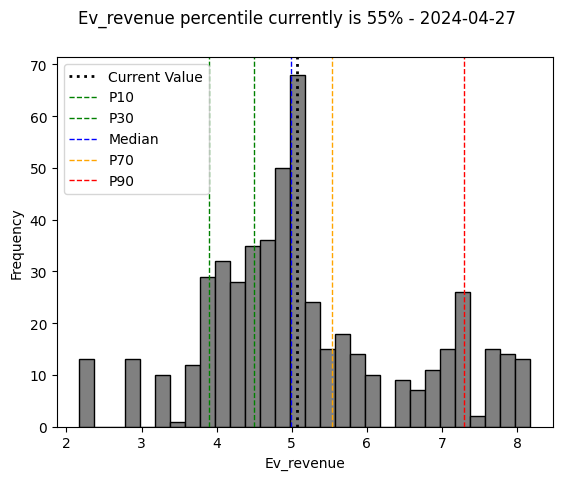

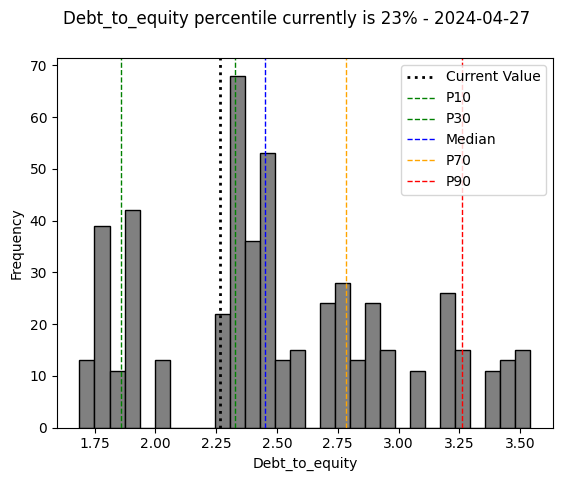

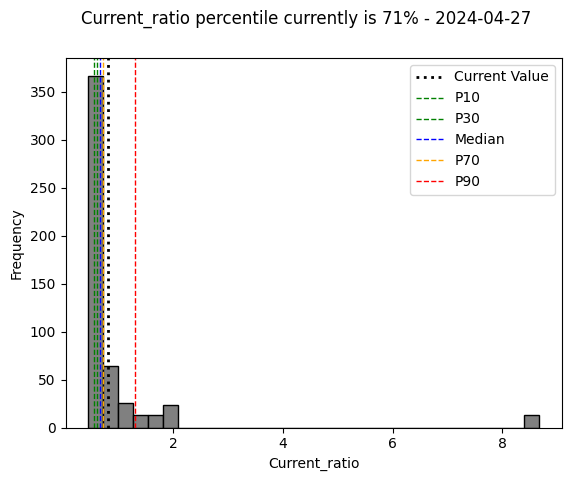

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.940663,-0.671760,0.196665,0.196413,0.067574,-0.246169,0.180571
roe,0.940663,1.000000,-0.829483,0.163450,0.199959,0.200041,0.068435,0.270481
pe_ratio,-0.671760,-0.829483,1.000000,0.509508,0.369812,0.349224,0.064614,-0.219320
pb_ratio,0.196665,0.163450,0.509508,1.000000,0.748551,0.492614,-0.263140,0.121318
ps_ratio,0.196413,0.199959,0.369812,0.748551,1.000000,0.878982,-0.167874,0.258080
ev_revenue,0.067574,0.200041,0.349224,0.492614,0.878982,1.000000,0.258480,0.176110
debt_to_equity,-0.246169,0.068435,0.064614,-0.263140,-0.167874,0.258480,1.000000,0.135339
current_ratio,0.180571,0.270481,-0.219320,0.121318,0.258080,0.176110,0.135339,1.000000


48 timestemos have been found!


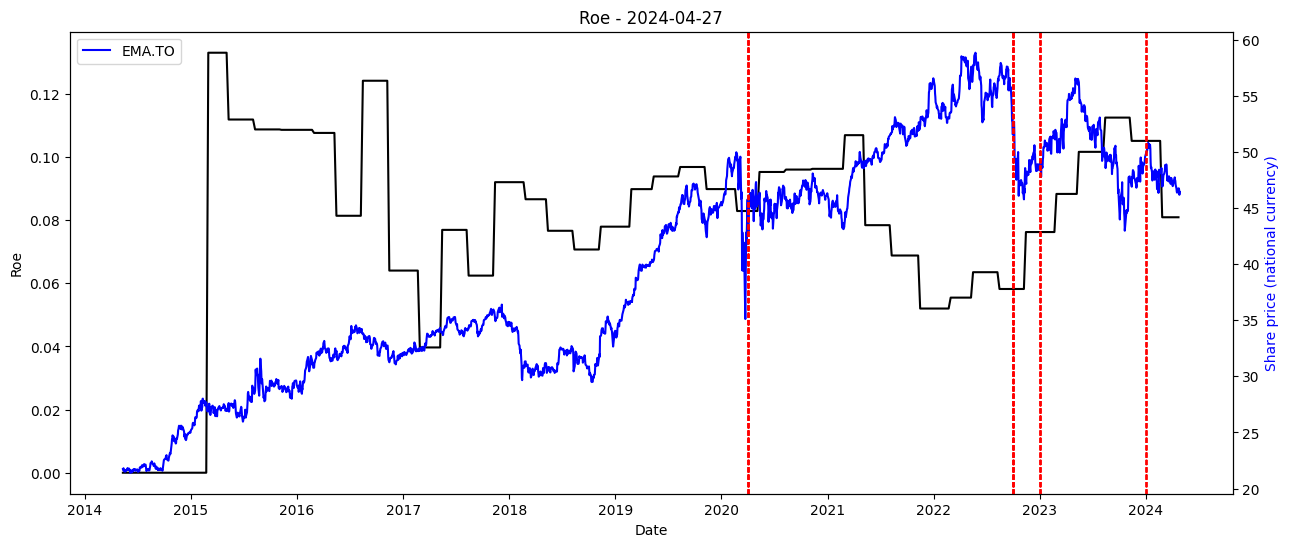

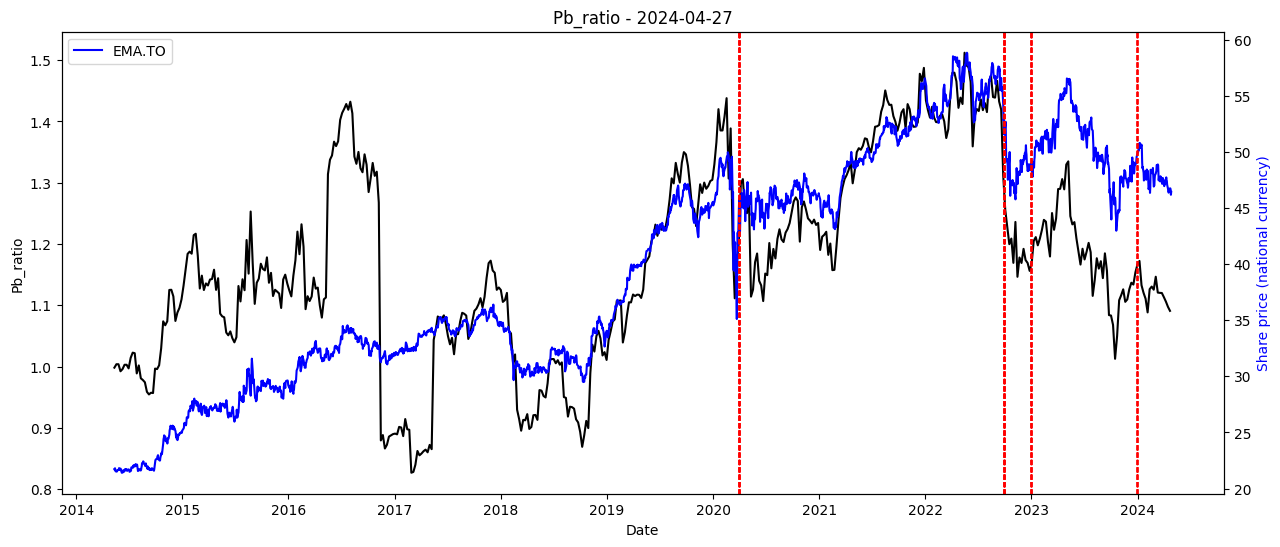

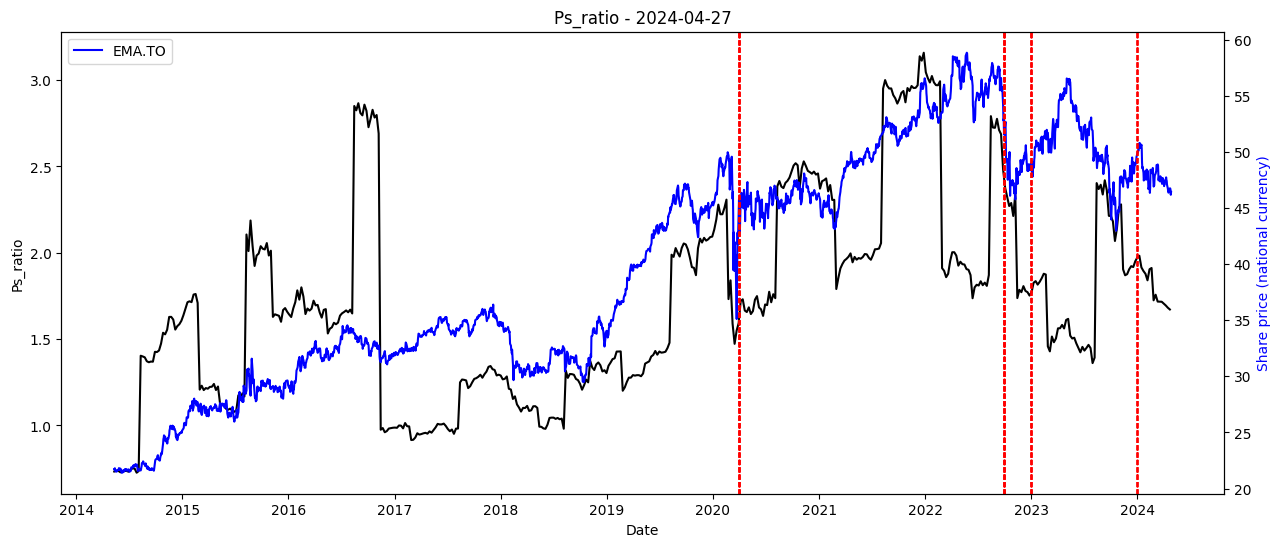

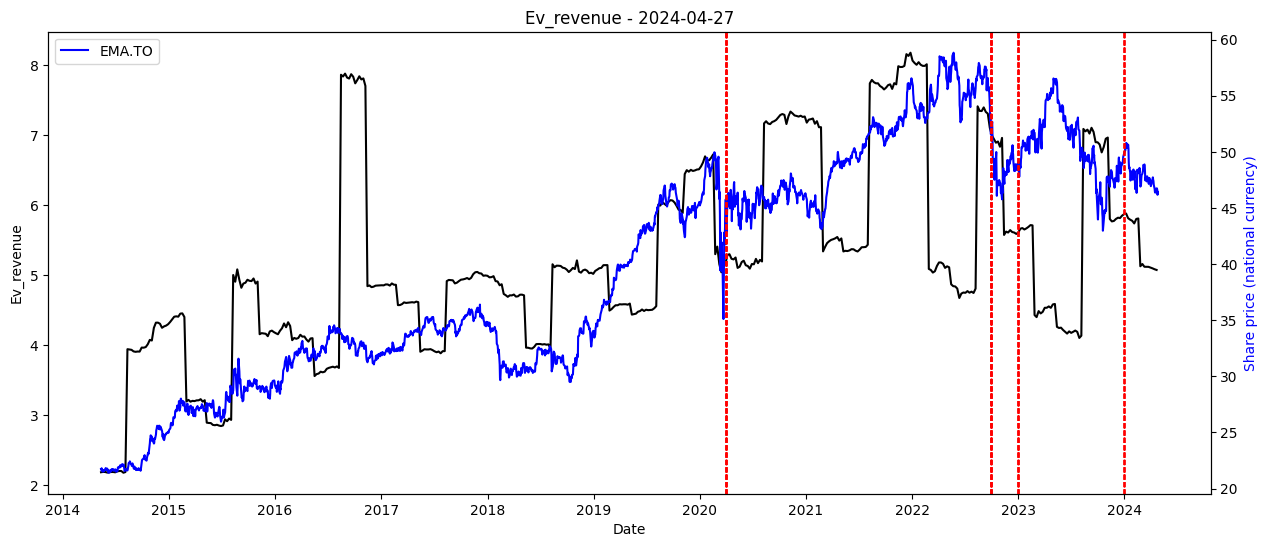

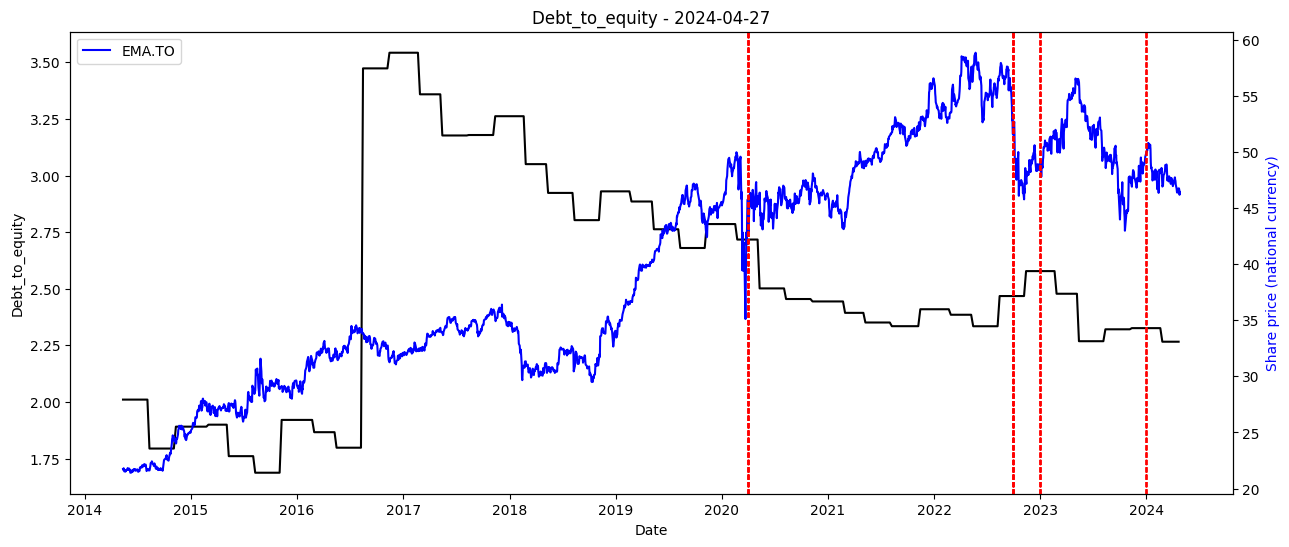

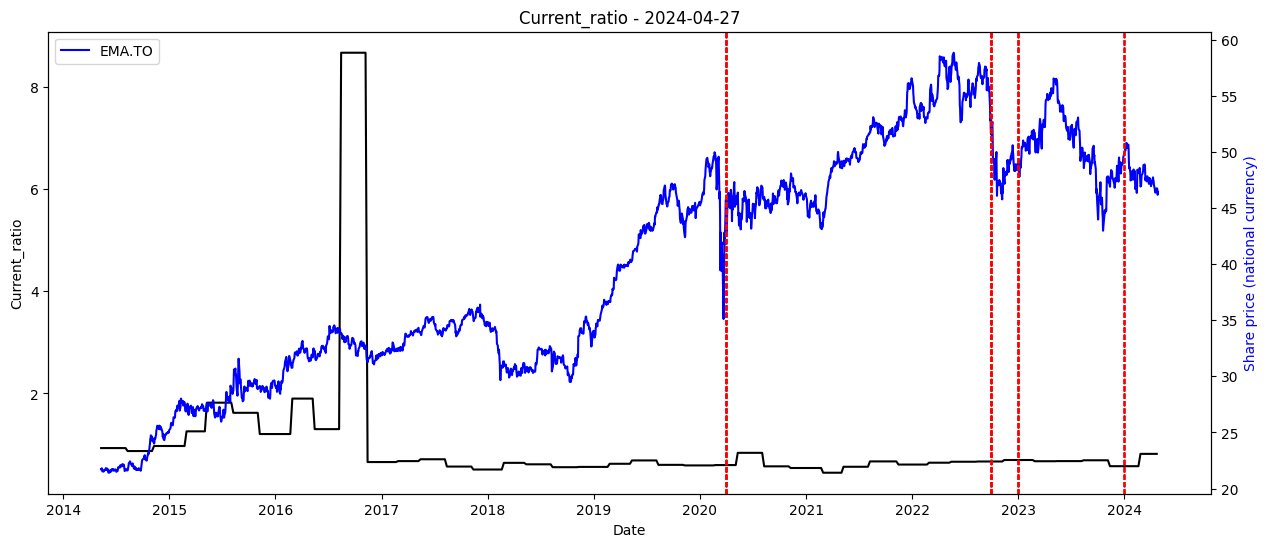

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )